In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV fil e I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/ANNOTATORS
/kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/SHA256SUMS.txt
/kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/RECORDS
/kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/SUBJECT-INFO
/kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/RECORDS-WITH-SEIZURES
/kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/shoeb-icml-2010.pdf
/kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb13/chb13_13.edf
/kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb13/chb13_37.edf
/kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb13/chb13_58.edf.seizures

In [2]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.9 MB/s eta 0:00:0000:01


In [3]:
# %% [code]
import os
import glob
import torch
import numpy as np
import mne
from tqdm.notebook import tqdm
import random

# PyTorch Geometric Imports
from torch_geometric.data import Data, InMemoryDataset, DataLoader
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

# Set random seeds for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Define directories:
# Read-only directory containing the raw .edf files (with subfolders, e.g., chb01, chb02, etc.)
READ_ONLY_DATA_DIR = "/kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0"
# Writable directory where processed data (data.pt) will be saved.
PROCESSED_DATA_DIR = "/kaggle/working/chbmit_processed"

print("Raw data directory:", READ_ONLY_DATA_DIR)
print("Processed data will be stored in:", PROCESSED_DATA_DIR)


Raw data directory: /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0
Processed data will be stored in: /kaggle/working/chbmit_processed


In [4]:
# %% [code]
class CHBMITEEGDataset(InMemoryDataset):
    """
    Custom dataset that:
      - Reads .edf files recursively from a read-only source_dir.
      - Extracts features per EEG channel (mean, std, and max absolute value).
      - Builds a simple chain graph (edges connecting consecutive channels).
      - Labels the data as seizure (1) if a corresponding ".edf.seizures" file exists, else non-seizure (0).
      - Saves the processed data in the writable directory (root).
    """
    def __init__(self, root, source_dir, transform=None, pre_transform=None):
        self.source_dir = source_dir  # read-only location of raw .edf files
        super().__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])
    
    @property
    def raw_file_names(self):
        # Recursively list all .edf files (relative paths) from the source_dir.
        edf_paths = glob.glob(os.path.join(self.source_dir, '**', '*.edf'), recursive=True)
        return [os.path.relpath(path, self.source_dir) for path in edf_paths]

    @property
    def processed_file_names(self):
        return ['data.pt']
    
    def download(self):
        # Data is already provided in the read-only directory.
        pass
    
    def process(self):
        data_list = []
        # Recursively find all .edf files
        edf_paths = glob.glob(os.path.join(self.source_dir, '**', '*.edf'), recursive=True)
        
        for edf_path in tqdm(edf_paths, desc="Processing .edf files"):
            try:
                # Load the .edf file using MNE
                raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
            except Exception as e:
                print(f"Error reading {edf_path}: {e}")
                continue
            
            # Select EEG channels only
            picks = mne.pick_types(raw.info, eeg=True)
            if len(picks) == 0:
                continue  # Skip if no EEG channels
            
            # Extract features for each EEG channel: mean, standard deviation, and max absolute value.
            signals = raw.get_data(picks=picks)  # shape: (num_channels, n_samples)
            features = []
            for ch_data in signals:
                mean_val = np.mean(ch_data)
                std_val = np.std(ch_data)
                max_abs = np.max(np.abs(ch_data))
                features.append([mean_val, std_val, max_abs])
            x = torch.tensor(features, dtype=torch.float)  # shape: (num_channels, 3)
            
            # Create a simple chain graph: connect each channel to its neighbor (bidirectionally)
            num_nodes = x.size(0)
            edge_list = []
            for i in range(num_nodes - 1):
                edge_list.append([i, i+1])
                edge_list.append([i+1, i])
            edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
            
            # Labeling: if a corresponding ".edf.seizures" file exists, label as seizure (1); otherwise 0.
            seizure_file = edf_path + '.seizures'
            label = 1 if os.path.exists(seizure_file) else 0
            y = torch.tensor([label], dtype=torch.long)
            
            data_list.append(Data(x=x, edge_index=edge_index, y=y))
        
        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])
        print("Processing complete. Total samples:", len(data_list))


In [ ]:
def process(self):
    data_list = []
    edf_paths = glob.glob(os.path.join(self.source_dir, '**', '*.edf'), recursive=True)
    
    for edf_path in tqdm(edf_paths, desc="Processing .edf files"):
        try:
            # Load the .edf file
            raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
            
            # Handle duplicate channel names by appending running numbers
            raw.rename_channels({ch: f"{ch}_{i}" for i, ch in enumerate(raw.ch_names)})

            # Since scaling factor info is missing, always apply manual scaling.
            scaling_factor = 1e-6  # Convert microvolts to volts
            print(f"Warning: No scaling factor found for {edf_path}. Applying manual scaling with factor {scaling_factor}.")
            raw.apply_function(lambda x: x * scaling_factor)
            
        except Exception as e:
            print(f"Error reading {edf_path}: {e}")
            continue
        
        # Select EEG channels only
        picks = mne.pick_types(raw.info, eeg=True)
        if len(picks) == 0:
            continue
        
        # Extract features: mean, standard deviation, and max absolute value per channel.
        signals = raw.get_data(picks=picks)
        features = [[np.mean(ch_data), np.std(ch_data), np.max(np.abs(ch_data))] for ch_data in signals]
        x = torch.tensor(features, dtype=torch.float)
        
        # Create a simple chain graph (bidirectional connections)
        num_nodes = x.size(0)
        edge_list = [[i, i+1] for i in range(num_nodes - 1)] + [[i+1, i] for i in range(num_nodes - 1)]
        edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
        
        # Labeling: if a corresponding ".edf.seizures" file exists, label as seizure (1); otherwise 0.
        label = 1 if os.path.exists(edf_path + '.seizures') else 0
        y = torch.tensor([label], dtype=torch.long)
        
        data_list.append(Data(x=x, edge_index=edge_index, y=y))
    
    data, slices = self.collate(data_list)
    torch.save((data, slices), self.processed_paths[0])
    print("Processing complete. Total samples:", len(data_list))


yeh atleast processing kr pa rha hai 


In [12]:
# %% [code]
# Instantiate the dataset.
dataset = CHBMITEEGDataset(
    root=PROCESSED_DATA_DIR,       # Writable directory for processed data.
    source_dir=READ_ONLY_DATA_DIR  # Read-only directory with raw .edf files.
)

print("Dataset size:", len(dataset))


Processing...


Processing .edf files:   0%|          | 0/686 [00:00<?, ?it/s]

<ipython-input-4-d9754af8bff7>:38: RuntimeWarning: Channel names are not unique, found duplicates for: {'-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
<ipython-input-4-d9754af8bff7>:38: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
<ipython-input-4-d9754af8bff7>:38: RuntimeWarning: Channel names are not unique, found duplicates for: {'-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
<ipython-input-4-d9754af8bff7>:38: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
<ipython-input-4-d9754af8bff7>:38: RuntimeWarning: Channel names are not unique, found duplicates for: {'-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_p

Processing complete. Total samples: 686
Dataset size: 686


Done!
<ipython-input-4-d9754af8bff7>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data, self.slices = torch.load(self.processed_paths[0])


Counter({0: 545, 1: 141})


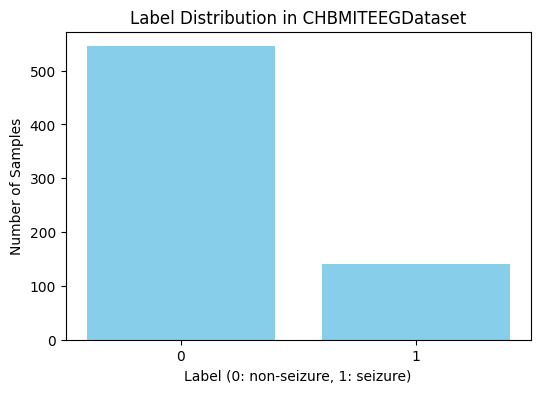

In [19]:
import matplotlib.pyplot as plt
from collections import Counter

# Assuming 'dataset' is your instance of CHBMITEEGDataset
# and each sample's label is stored in data.y as a single-element tensor

# Collect labels from the dataset
labels = [data.y.item() for data in dataset]

# Count occurrences for each label (e.g., 0: non-seizure, 1: seizure)
label_counts = Counter(labels)
print(label_counts)
# Sort the counts by label for consistent plotting
sorted_labels = sorted(label_counts.items())
x_labels = [str(label) for label, _ in sorted_labels]
counts = [count for _, count in sorted_labels]

# Plotting the label distribution
plt.figure(figsize=(6, 4))
plt.bar(x_labels, counts, color='skyblue')
plt.xlabel('Label (0: non-seizure, 1: seizure)')
plt.ylabel('Number of Samples')
plt.title('Label Distribution in CHBMITEEGDataset')
plt.show()


In [13]:
# %% [code]
# Instantiate the dataset. This will process the raw files on the first run.
dataset = CHBMITEEGDataset(
    root=PROCESSED_DATA_DIR,       # Writable directory for processed data.
    source_dir=READ_ONLY_DATA_DIR  # Read-only directory with raw .edf files.
)

print("Dataset size:", len(dataset))


Dataset size: 686


<ipython-input-4-d9754af8bff7>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data, self.slices = torch.load(self.processed_paths[0])


In [14]:
# %% [code]
from torch_geometric.nn import GCNConv, global_mean_pool, global_max_pool, BatchNorm

class ImprovedGCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes, dropout=0.5):
        super(ImprovedGCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.bn1 = BatchNorm(hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.bn2 = BatchNorm(hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.bn3 = BatchNorm(hidden_channels)
        # We'll combine global mean and max pooling for richer features.
        self.lin = torch.nn.Linear(2 * hidden_channels, num_classes)
        self.dropout = dropout
        
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        x = self.conv3(x, edge_index)
        x = self.bn3(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        # Global pooling: combine mean and max pooling.
        
        #Average pooling: Looks at the overall trend across all electrodes.
        #Max pooling: Finds the strongest activity from any electrode.

        x_mean = global_mean_pool(x, batch)
        x_max = global_max_pool(x, batch)
        x = torch.cat([x_mean, x_max], dim=1)
        
        x = self.lin(x)
        return F.log_softmax(x, dim=1)


#backpropagation

# Instantiate the improved model with 3 input channels (update to 4 if needed)
model = ImprovedGCN(in_channels=3, hidden_channels=32, num_classes=2, dropout=0.5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
# Learning rate scheduler that reduces lr on plateau.
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [27]:
# to be remo
# %% [code]
# Split dataset into training and validation sets (80/20 split)
train_ratio = 0.8
num_train = int(len(dataset) * train_ratio)
num_val = len(dataset) - num_train
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [num_train, num_val])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

def train():
    model.train()
    total_loss = 0
    # Disable interactive widgets in tqdm by setting disable=True
    for data in tqdm(train_loader, desc="Training", disable=True):
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = F.nll_loss(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def validate():
    model.eval()
    total_loss = 0
    total_correct = 0
    total_graphs = 0
    # Disable interactive widgets in tqdm by setting disable=True
    with torch.no_grad():
        for data in tqdm(val_loader, desc="Validating", disable=True):
            data = data.to(device)
            out = model(data)
            loss = F.nll_loss(out, data.y)
            total_loss += loss.item()
            pred = out.argmax(dim=1)
            total_correct += (pred == data.y).sum().item()
            total_graphs += data.num_graphs
    avg_loss = total_loss / len(val_loader)
    accuracy = total_correct / total_graphs
    return avg_loss, accuracy

num_epochs = 50
patience = 10
best_val_loss = float('inf')
counter = 0

for epoch in range(1, num_epochs+1):
    print(f"Epoch {epoch}/{num_epochs}")
    train_loss = train()
    val_loss, val_accuracy = validate()
    print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
    
    # Step the scheduler on the validation loss.
    scheduler.step(val_loss)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered!")
            break


Epoch 1/50
Train Loss: 0.4748, Val Loss: 0.5876, Val Accuracy: 0.7391
Epoch 2/50
Train Loss: 0.4705, Val Loss: 0.5960, Val Accuracy: 0.7391
Epoch 3/50
Train Loss: 0.4675, Val Loss: 0.5879, Val Accuracy: 0.7391
Epoch 4/50
Train Loss: 0.4788, Val Loss: 0.5857, Val Accuracy: 0.7391
Epoch 5/50
Train Loss: 0.4623, Val Loss: 0.5839, Val Accuracy: 0.7391
Epoch 6/50
Train Loss: 0.4827, Val Loss: 0.5980, Val Accuracy: 0.7391
Epoch 7/50
Train Loss: 0.4810, Val Loss: 0.5813, Val Accuracy: 0.7391
Epoch 8/50
Train Loss: 0.4642, Val Loss: 0.5789, Val Accuracy: 0.7391
Epoch 9/50
Train Loss: 0.4756, Val Loss: 0.5776, Val Accuracy: 0.7391
Epoch 10/50
Train Loss: 0.4686, Val Loss: 0.5820, Val Accuracy: 0.7391
Epoch 11/50
Train Loss: 0.4636, Val Loss: 0.5754, Val Accuracy: 0.7391
Epoch 12/50
Train Loss: 0.4685, Val Loss: 0.5740, Val Accuracy: 0.7391
Epoch 13/50
Train Loss: 0.4685, Val Loss: 0.5744, Val Accuracy: 0.7391
Epoch 14/50
Train Loss: 0.5014, Val Loss: 0.5821, Val Accuracy: 0.7391
Epoch 15/50
Tra

# FINAL OUTPUT

In [20]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool, global_max_pool, BatchNorm

# Updated ImprovedGCN model remains the same
class ImprovedGCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes, dropout=0.3):
        super(ImprovedGCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.bn1 = BatchNorm(hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.bn2 = BatchNorm(hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.bn3 = BatchNorm(hidden_channels)
        self.lin = torch.nn.Linear(2 * hidden_channels, num_classes)
        self.dropout = dropout
        
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        x = self.conv3(x, edge_index)
        x = self.bn3(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        # Global pooling: combine mean and max pooling.
        x_mean = global_mean_pool(x, batch)
        x_max = global_max_pool(x, batch)
        x = torch.cat([x_mean, x_max], dim=1)
        
        x = self.lin(x)
        return F.log_softmax(x, dim=1)

# Instantiate model with updated hyperparameters
model = ImprovedGCN(in_channels=3, hidden_channels=32, num_classes=2, dropout=0.3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

# Compute class weights based on your distribution:
# 545 samples for class 0 and 141 for class 1.
total_samples = 545 + 141  # 686
weight_class_0 = total_samples / (2 * 545)  # ~0.629
weight_class_1 = total_samples / (2 * 141)  # ~2.433
weights = torch.tensor([weight_class_0, weight_class_1], device=device)

# Example training and evaluation loops using weighted loss
def train(model, optimizer, loader):
    model.train()
    total_loss = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        # Use weighted loss to account for imbalance
        loss = F.nll_loss(output, data.y, weight=weights)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader):
    model.eval()
    total_loss = 0
    correct = 0
    total_samples = 0
    for data in loader:
        data = data.to(device)
        output = model(data)
        loss = F.nll_loss(output, data.y, weight=weights)
        total_loss += loss.item()
        pred = output.max(1)[1]
        correct += pred.eq(data.y).sum().item()
        total_samples += data.num_graphs  # Assuming data.num_graphs gives the batch size
    return total_loss / len(loader), correct / total_samples

# Training loop for 50 epochs
num_epochs = 50
for epoch in range(1, num_epochs + 1):
    train_loss = train(model, optimizer, train_loader)
    val_loss, val_accuracy = evaluate(model, val_loader)
    scheduler.step(val_loss)
    print(f"Epoch {epoch}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")


Epoch 1/50
Train Loss: 0.8029, Val Loss: 0.6981, Val Accuracy: 0.7899
Epoch 2/50
Train Loss: 0.7025, Val Loss: 0.6991, Val Accuracy: 0.7899
Epoch 3/50
Train Loss: 0.7119, Val Loss: 2.7404, Val Accuracy: 0.7899
Epoch 4/50
Train Loss: 0.7074, Val Loss: 0.7990, Val Accuracy: 0.7899
Epoch 5/50
Train Loss: 0.6995, Val Loss: 1.9298, Val Accuracy: 0.7899
Epoch 6/50
Train Loss: 0.6957, Val Loss: 1.4074, Val Accuracy: 0.7899
Epoch 7/50
Train Loss: 0.7117, Val Loss: 1.1428, Val Accuracy: 0.7899
Epoch 8/50
Train Loss: 0.6865, Val Loss: 0.7186, Val Accuracy: 0.2101
Epoch 9/50
Train Loss: 0.6865, Val Loss: 0.8984, Val Accuracy: 0.7899
Epoch 10/50
Train Loss: 0.7015, Val Loss: 0.6952, Val Accuracy: 0.7899
Epoch 11/50
Train Loss: 0.6775, Val Loss: 0.9389, Val Accuracy: 0.7899
Epoch 12/50
Train Loss: 0.6858, Val Loss: 0.7053, Val Accuracy: 0.7899
Epoch 13/50
Train Loss: 0.6797, Val Loss: 0.7865, Val Accuracy: 0.7971
Epoch 14/50
Train Loss: 0.6880, Val Loss: 0.7405, Val Accuracy: 0.7899
Epoch 15/50
Tra

In [16]:
# this is just an expreiment 

import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool, global_max_pool, BatchNorm

# Updated ImprovedGCN model with lower dropout
class ImprovedGCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes, dropout=0.3):
        super(ImprovedGCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.bn1 = BatchNorm(hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.bn2 = BatchNorm(hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.bn3 = BatchNorm(hidden_channels)
        self.lin = torch.nn.Linear(2 * hidden_channels, num_classes)
        self.dropout = dropout
        
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        x = self.conv3(x, edge_index)
        x = self.bn3(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        # Combine global mean and max pooling
        x_mean = global_mean_pool(x, batch)
        x_max = global_max_pool(x, batch)
        x = torch.cat([x_mean, x_max], dim=1)
        
        x = self.lin(x)
        return F.log_softmax(x, dim=1)

# Instantiate the improved model with 3 input channels (update to 4 if needed)
model = ImprovedGCN(in_channels=3, hidden_channels=32, num_classes=2, dropout=0.3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Lower learning rate for a more stable training process
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

# Example training and evaluation loop (assuming train_loader and val_loader are defined)
def train(model, optimizer, loader):
    model.train()
    total_loss = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader):
    model.eval()
    total_loss = 0
    correct = 0
    total_samples = 0
    for data in loader:
        data = data.to(device)
        output = model(data)
        loss = F.nll_loss(output, data.y)
        total_loss += loss.item()
        pred = output.max(1)[1]
        correct += pred.eq(data.y).sum().item()
        total_samples += data.num_graphs  # or len(data.y)
    return total_loss / len(loader), correct / total_samples

num_epochs = 50
for epoch in range(1, num_epochs+1):
    train_loss = train(model, optimizer, train_loader)
    val_loss, val_accuracy = evaluate(model, val_loader)
    scheduler.step(val_loss)
    print(f"Epoch {epoch}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")


Epoch 1/50
Train Loss: 0.5404, Val Loss: 0.5395, Val Accuracy: 0.7899
Epoch 2/50
Train Loss: 0.5309, Val Loss: 0.6543, Val Accuracy: 0.7899
Epoch 3/50
Train Loss: 0.5528, Val Loss: 0.7466, Val Accuracy: 0.2101
Epoch 4/50
Train Loss: 0.5199, Val Loss: 1.1998, Val Accuracy: 0.2101
Epoch 5/50
Train Loss: 0.5092, Val Loss: 0.5497, Val Accuracy: 0.7899
Epoch 6/50
Train Loss: 0.5097, Val Loss: 0.5259, Val Accuracy: 0.7899
Epoch 7/50
Train Loss: 0.5108, Val Loss: 0.9757, Val Accuracy: 0.7899
Epoch 8/50
Train Loss: 0.5228, Val Loss: 0.7105, Val Accuracy: 0.3043
Epoch 9/50
Train Loss: 0.5069, Val Loss: 1.8254, Val Accuracy: 0.7899
Epoch 10/50
Train Loss: 0.5144, Val Loss: 0.5028, Val Accuracy: 0.7899
Epoch 11/50
Train Loss: 0.4974, Val Loss: 0.6552, Val Accuracy: 0.7899
Epoch 12/50
Train Loss: 0.5039, Val Loss: 0.5503, Val Accuracy: 0.7899
Epoch 13/50
Train Loss: 0.5222, Val Loss: 0.7813, Val Accuracy: 0.7899
Epoch 14/50
Train Loss: 0.4884, Val Loss: 0.5379, Val Accuracy: 0.7899
Epoch 15/50
Tra

## this can be displayed


# iske bad udarana hai


In [ ]:
loss = F.nll_loss(output, data.y, weight=weights)
